# *Importando as bibliotecas necessárias*

In [12]:
import warnings

import pandas as pd
import numpy as np

import time

from typing import Union

from numpy import linalg as la
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [3]:
warnings.filterwarnings("ignore")

In [ ]:
params = {
    'delay': 2, # Refere-se a quantos valores passados da série temporal são usados como entrada para prever o próximo valor.
    'alfa': 1000, # Fator de regularização (?)
    'lamb': 0.99, # Controla o quanto o modelo "esquece" dados antigos ao atualizar seus parâmetros.
    
    # Definidos conforme exemplo do código inicial
    'centers': np.array([[0.10, 0.20],[0.80, 0.60]]), 
    # Definidos conforme exemplo do código inicial
    'sigmas': np.array([[0.55, 0.40],[0.55, 0.40]]), 
    
    'n': 999,     # linha do arquivo data onde está o último dado de treinamento (data 999)
    'm': 2524    # linha do arquivo data onde o último dado de teste (data 2524)
}

#
delay = params['delay']
alfa = params['alfa']
lamb = params['lamb']

#
centers = params['centers']
sigmas = params['sigmas']

#
n = params['n']
m = params['m']

In [6]:
df = pd.read_excel('dataBTC.xlsx')

df

,y,Unnamed: 1,max,min
0,0.113554,NaN,1.755024,0.000132
1,0.059096,NaN,NaN,NaN
2,0.058521,NaN,NaN,NaN
3,0.080239,NaN,NaN,NaN
4,0.048047,NaN,NaN,NaN
...,...,...,...,...
2520,0.019472,NaN,NaN,NaN
2521,0.009534,NaN,NaN,NaN
2522,0.006666,NaN,NaN,NaN
2523,0.006562,NaN,NaN,NaN


In [7]:
data = df['y'].to_numpy()   

data

array([0.11355383, 0.05909608, 0.05852059, ..., 0.0066655 , 0.0065616 ,
       0.0021047 ])

In [ ]:
# Inicializa Xtrain, ytrain, Xtest e ytest.

Xtrain = np.zeros((n-delay+1,delay)) # Matriz de entradas do conjunto de treino, cada linha com 'delay' lags

ytrain = np.zeros(n-delay+1)  # Vetor de saídas (targets) do treino, correspondentes aos valores futuros após os lags

Xtest  = np.zeros((m-n,delay)) # Matriz de entradas do conjunto de teste, com mesma estrutura de lags

ytest  = np.zeros(m-n) # Vetor de saídas (targets) do teste, para avaliar a previsão do modelo

In [11]:
type('a')

str

In [ ]:
def plot_line_series(
        series: Union[pd.Series, np.ndarray], 
        xlabel:str = 'x', 
        ylabel:str = 'y', 
        title:str = 'Line Plot', 
        label:str='Series'
    ) -> None:
    
    """
        Description:
            Plota uma série temporal ou sequência de valores como gráfico de linha.
        Args:
            series (pd.Series | np.ndarray): Sequência de valores a serem plotados.
            xlabel (str) [opcional]: Rótulo do eixo x. [Padrão: 'x'.]
            ylabel (str) [opcional]: Rótulo do eixo y. [Padrão: 'y'.]
            title (str) [opcional]: Título do gráfico. [Padrão: 'Line Plot'.]
            label (str) [opcional]: Legenda da série. [Padrão: 'Series'].
        Return:
            A função não retorna nada, apenas exibe um gráfico.
    """
    
    
    plt.figure() # Cria uma nova figura para o gráfico
    
    plt.plot(series, label=label) # Plota a série no gráfico com a legenda definida
    
    plt.xlabel(xlabel) # Define o rótulo do eixo x
    
    plt.ylabel(ylabel) # Define o rótulo do eixo y
    
    plt.title(title) # Define o título do gráfico
    
    plt.legend() # Exibe a legenda no gráfico
    
    plt.show() # Exibe o gráfico gerado

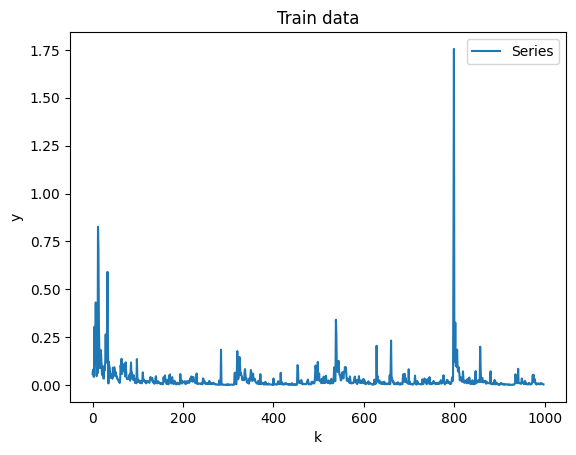

In [ ]:
plot_line_series(ytrain, 'k', 'y', 'Train data')

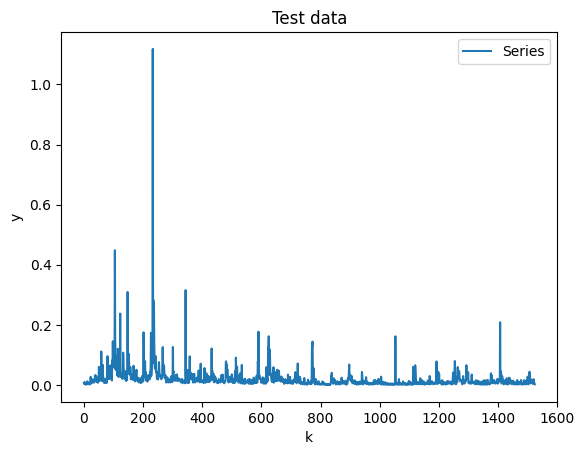

In [148]:
plot_line_series(ytest, 'k', 'y', 'Test data')

In [97]:
def create_lagged_dataset(data, start_idx, end_idx, delay, is_training=True):
    """
    Cria um conjunto de dados com defasagem (lagged dataset) a partir de uma série temporal.
    
    Parâmetros:
    -----------
    data : array-like
        Série temporal original.
    start_idx : int
        Índice inicial para o conjunto de dados.
    end_idx : int
        Índice final para o conjunto de dados.
    delay : int
        Número de defasagens (lags) a serem consideradas.
    is_training : bool, opcional (padrão=True)
        Se True, cria conjunto de treino; se False, cria conjunto de teste.
        
    Retorna:
    --------
    X : numpy.ndarray
        Matriz de features com as defasagens, de formato (n_samples, delay).
    y : numpy.ndarray
        Vetor de alvos, de formato (n_samples,).
    """
    import numpy as np
    
    if is_training:
        # Para o conjunto de treino
        n_samples = end_idx - start_idx - delay + 1
        X = np.zeros((n_samples, delay))
        y = np.zeros(n_samples)
        
        for i in range(n_samples):
            for j in range(delay):
                X[i, j] = data[start_idx + i + j]
            y[i] = data[start_idx + i + delay]
    else:
        # Para o conjunto de teste
        n_samples = end_idx - start_idx
        X = np.zeros((n_samples, delay))
        y = np.zeros(n_samples)
        
        for i in range(n_samples):
            for j in range(delay):
                X[i, j] = data[start_idx - delay + 1 + i + j]
            y[i] = data[start_idx + i + 1]
    
    return X, y

In [127]:
Xtrain, ytrain = create_lagged_dataset(data, 0, n,delay, True)

Xtest, ytest = create_lagged_dataset(data, n, m, delay, False)

In [128]:
def gaussmf(x, c, s):
    aux = (x - c)/s
    z = np.exp(-(aux*aux)/2)
    return z

In [129]:
def gaussgranules(x, centers, sigmas):
    """
    x       : vetor de entrada (dimensão d)
    centers : array de shape (N, d) com os centros das N regras
    sigmas  : array de shape (N, d) com os desvios padrão das N regras
    """
    N, d = centers.shape
    activations = []

    for i in range(N):
        mu = 1.0
        for j in range(d):
            mu *= gaussmf(x[j], centers[i, j], sigmas[i, j])
        activations.append(mu)
    
    return np.array(activations)

In [130]:
def initialize_parameters(Xtrain, Xtest):
    """
    Inicializa os parâmetros necessários para o modelo adaptativo de sistema linear (ALSM).
    
    Parâmetros:
    ----------
    Xtrain : numpy.ndarray
        Conjunto de dados de treinamento, onde cada linha representa uma amostra de entrada.
    Xtest : numpy.ndarray
        Conjunto de dados de teste, onde cada linha representa uma amostra de entrada.
    
    Retorna:
    --------
    o : numpy.ndarray
        Vetor de saídas do modelo para todos os dados (treinamento e teste).
    OT : numpy.ndarray
        Vetor com as saídas para o conjunto de dados de treinamento.
    OS : numpy.ndarray
        Vetor com as saídas para o conjunto de dados de teste.
    DA : numpy.ndarray
        Matriz para armazenar os dados de adaptação.
    P : numpy.ndarray
        Matriz de regularização para atualização dos parâmetros (usada na adaptação do modelo).
    G : numpy.ndarray
        Outra matriz de regularização para atualização dos parâmetros.
    a : numpy.ndarray
        Vetor de parâmetros que armazenam as características do modelo.
    u : numpy.ndarray
        Vetor com os parâmetros do modelo adaptativo.
    norm : numpy.ndarray
        Vetor para armazenar a norma dos parâmetros do modelo durante o treinamento.
    kz : float
        Constante de normalização para o kernel Gaussiano.
    zs : float
        Parâmetro de ajuste para o kernel Gaussiano.
    r : int
        Número de regras ou granulações do modelo, determinado pela entrada Xtrain.
    ndatatrain : int
        Número de amostras no conjunto de dados de treinamento.
    ndatatest : int
        Número de amostras no conjunto de dados de teste.
    ndata : int
        Número total de amostras, somando os dados de treinamento e teste.
    """
    
    # Calcula o número de regras, que é baseado nas granulações Gaussiana
    r = gaussgranules(Xtrain[0], params['centers'], params['sigmas']).size  
    
    # Define o número de amostras nos conjuntos de treinamento e teste
    ndatatrain = Xtrain.shape[0]
    ndatatest = Xtest.shape[0]
    ndata = ndatatrain + ndatatest
    
    # Inicializa os vetores de saída e os dados de adaptação
    o = np.zeros((ndata,))  # Vetor de saídas do modelo para todos os dados
    OT = np.zeros((ndatatrain,))  # Saídas para os dados de treinamento
    OS = np.zeros((ndatatest,))  # Saídas para os dados de teste
    DA = np.zeros((ndata, 2*r))  # Matriz de adaptação
    
    # Inicializa as matrizes de regularização para P e G
    P = params['alfa'] * np.eye(2*r)  # Matriz de regularização para P (baseada em alfa)
    G = params['alfa'] * np.eye(2*r)  # Matriz de regularização para G (baseada em alfa)
    
    # Inicializa os vetores de parâmetros a e u (valores do modelo)
    a = np.zeros((2*r,))  # Parâmetros do modelo (2 vezes o número de regras)
    u = np.zeros((2*r,))  # Parâmetros adaptativos do modelo
    
    # Inicializa o vetor de norma dos parâmetros do modelo
    norm = np.zeros((ndatatrain,))  # Normas dos parâmetros durante o treinamento
    
    # Constantes usadas para o kernel Gaussiano
    kc = 1/np.sqrt(2*np.pi)  # Constante normalizadora do kernel Gaussiano
    ze = 1.0  # Parâmetro zeta (controla a largura da distribuição Gaussiana)
    kz = kc * (1/(ze**3))  # Constante de normalização do kernel Gaussiano
    zs = 1/(2*ze**2)  # Parâmetro de ajuste da largura do kernel Gaussiano
    
    # Retorna os parâmetros e variáveis iniciais
    return o, OT, OS, DA, P, G, a, u, norm, kz, zs, r, ndatatrain, ndatatest, ndata


In [131]:
o, OT, OS, DA, P, G, a, u, norm, kz, zs, r, ndatatrain, ndatatest, ndata = initialize_parameters(Xtrain, Xtest)

In [ ]:
def update_model_parameters(P, u, a, y_true, psi, lamb):
    """
    Atualiza os parâmetros do modelo (P e u) usando o algoritmo de filtragem adaptativa.

    Parâmetros:
    - P: matriz de covariância.
    - u: vetor de parâmetros do modelo.
    - a: vetor de entrada transformado pelas regras fuzzy.
    - y_true: valor alvo (real) do dado de treinamento atual.
    - psi: valor de ativação do kernel gaussiano.
    - lamb: fator de esquecimento.

    Retorna:
    - P atualizado
    - u atualizado
    """
    b = lamb + psi * np.dot(np.dot(a, P), a)
    Pa = np.dot(P, a)
    P -= (psi * np.outer(Pa, Pa)) / b
    P /= lamb
    u += psi * np.dot(P, a) * (y_true - np.dot(a, u))
    return P, u

In [136]:
def train_model(Xtrain, ytrain, r, lamb, alfa, kz, zs):
    """
    Treina um modelo fuzzy adaptativo com atualização recursiva dos parâmetros.

    Parâmetros:
    - Xtrain: matriz com os dados de entrada do treinamento (n_amostras x n_features).
    - ytrain: vetor com os valores alvo (reais) do treinamento.
    - r: número de regras fuzzy (granulações gaussianas).
    - lamb: fator de esquecimento.
    - alfa: fator de regularização inicial.
    - kz, zs: constantes do kernel gaussiano. Se None, serão calculadas automaticamente.

    Retorna:
    - OT: vetor com as saídas previstas para os dados de treinamento.
    - norm: vetor com a norma de u a cada iteração.
    """
    ndatatrain = Xtrain.shape[0]
    OT = np.zeros(ndatatrain)
    norm = np.zeros(ndatatrain)

    # Constantes do kernel, se não passadas
    if kz is None or zs is None:
        kc = 1 / np.sqrt(2 * np.pi)
        ze = 1.0
        kz = kc / (ze**3)
        zs = 1 / (2 * ze**2)

    # Inicializações
    P = alfa * np.eye(2 * r)
    u = np.zeros(2 * r)
    a = np.zeros(2 * r)

    for t in range(ndatatrain):
        x = Xtrain[t]
        d = gaussgranules(x, centers, sigmas)
        sumd = np.sum(d)

        # Montagem do vetor a
        for j in range(r):
            a[2 * j]     = d[j]**2 / sumd
            a[2 * j + 1] = d[j]    / sumd

        # Cálculo da saída e psi
        y_pred = np.dot(a, u)
        sq = np.abs(ytrain[t] - y_pred)**2
        psi = kz * np.exp(-sq / zs)

        # Atualização dos parâmetros
        P, u = update_model_parameters(P, u, a, ytrain[t], psi, lamb)

        # Armazenamento da saída e norma
        OT[t] = np.dot(a, u)
        norm[t] = la.norm(u)

    return OT, norm


In [138]:
# Medir tempo de CPU
st = time.process_time()

# Treinamento
OT, norm = train_model(
    Xtrain=Xtrain,
    ytrain=ytrain,
    r=r,
    lamb=lamb,
    alfa=alfa,
    kz=kz,
    zs=zs
)

et = time.process_time()
print('cpu execution time training:', et - st, 'seconds')

cpu execution time training: 0.17209211899999843 seconds


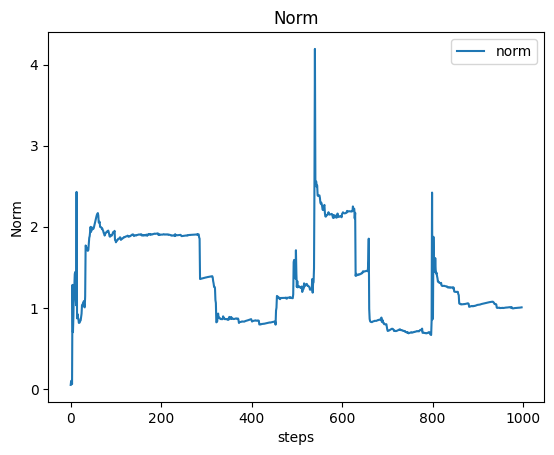

In [150]:
plot_line_series(norm, 'steps', 'Norm', 'Norm', 'norm')

In [140]:
print('mse  train =', mean_squared_error(ytrain, OT))
print('nrms train =', root_mean_squared_error(ytrain, OT)/ytrain.std())
print('rmse train =', root_mean_squared_error(ytrain, OT))
print('mae  train =', mean_absolute_error(ytrain, OT))

mse  train = 0.00414300389954774
nrms train = 0.7879801733610144
rmse train = 0.06436617045892773
mae  train = 0.01838947390363763


In [151]:
def plot_comparison_series(true_values, predicted_values, xlabel='x', ylabel='y',
                           title='Comparison Plot', legend_labels=('True', 'Predicted'), ylim=None):
    """
    Plota duas séries para comparar valores reais e previstos, por exemplo.

    Parâmetros:
    -----------
    true_values : array-like
        Série com valores reais.
    predicted_values : array-like
        Série com valores previstos ou estimados.
    xlabel : str, opcional
        Rótulo do eixo x. Padrão: 'x'.
    ylabel : str, opcional
        Rótulo do eixo y. Padrão: 'y'.
    title : str, opcional
        Título do gráfico. Padrão: 'Comparison Plot'.
    legend_labels : tuple(str, str), opcional
        Rótulos da legenda para as duas séries. Padrão: ('True', 'Predicted').
    ylim : tuple(float, float), opcional
        Limites para o eixo y. Padrão: None.
    """
    plt.figure()
    plt.plot(true_values, label=legend_labels[0])
    plt.plot(predicted_values, label=legend_labels[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if ylim:
        plt.ylim(ylim)
    plt.legend(loc='upper right')
    plt.show()


Text(0.5, 1.0, 'Forecast (train)')

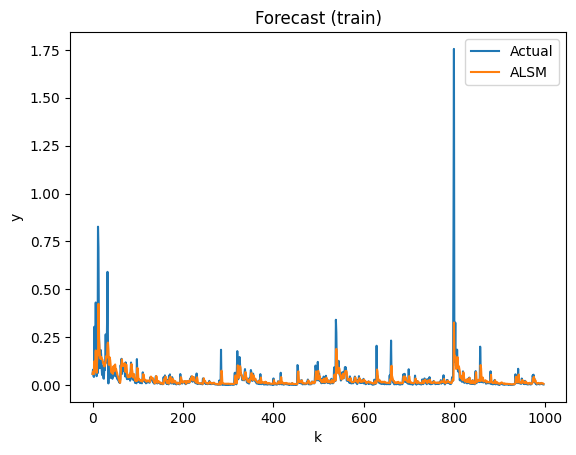

In [141]:
plt.figure()
plt.plot(ytrain, label="Actual")
plt.plot(OT, label="ALSM")
plt.legend(loc='upper right')
plt.xlabel('k')
plt.ylabel('y')
plt.title('Forecast (train)')
#plt.ylim([1, 3])

In [142]:
print('MSE   test =', mean_squared_error(ytest, OS))
print('NRMSE test =', root_mean_squared_error(ytest, OS)/ytest.std())
print('RMSE  test =', root_mean_squared_error(ytest, OS))
print('MAE   test =', mean_absolute_error(ytest, OS))

MSE   test = 0.001194992284599163
NRMSE test = 0.836646991940878
RMSE  test = 0.03456866043975616
MAE   test = 0.011450247775353741


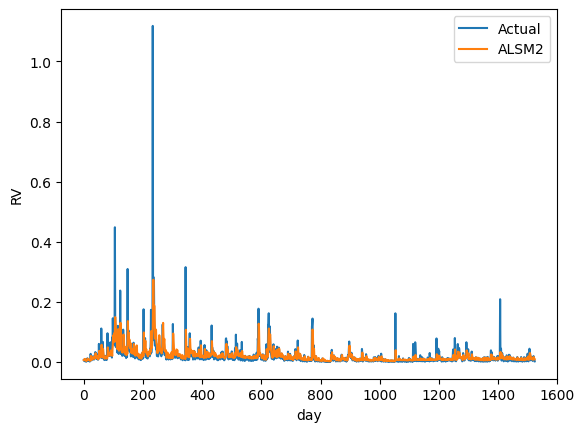

In [143]:
plt.figure()
plt.plot(ytest, label="Actual")
plt.plot(OS, label="ALSM2")
plt.legend(loc='upper right')
plt.xlabel('day')
plt.ylabel('RV')
#plt.title('Forecast (test)')
#plt.ylim([0, 2])

plt.show()